# PyMC model

This notebook shows a PyMC model that incorporates basket + clustering

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import sys
from os.path import exists

sys.path.append('..')
sys.path.append('.')

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import random

import pandas as pd
import pymc as pm
from sklearn.metrics import mean_squared_error
from scipy.stats import halfnorm
import math
from statsmodels.formula.api import glm
import statsmodels.api as sm
import seaborn as sns
from loguru import logger

from scipy import stats
from scipy.special import expit as logistic

In [4]:
from pyBasket.common import load_obj
from pyBasket.model import get_model_simple, get_model_bhm_nc, get_model_pyBasket_nc
from pyBasket.env import Site, TrueResponseSite, TrueResponseWithClusteringSite, PatientData

## 1. Generate some data

In [5]:
# Set the seed value
seed_value = 42

# Set `random` seed
random.seed(seed_value)

# Set `numpy` seed
np.random.seed(seed_value)

New generative process

In [6]:
# Define number of patients, tissues, and clusters
n_patients = 500
n_tissues = 25
n_clusters = 10

# Generate tissue and cluster indices for each patient
basket_coords = np.arange(n_tissues)
cluster_coords = np.arange(n_clusters)
basket_idx = np.random.choice(basket_coords, size=n_patients)
cluster_idx = np.random.choice(cluster_coords, size=n_patients)

# Generate synthetic responsiveness data
theta_basket = np.random.normal(loc=0, scale=2, size=n_tissues)

# Generate unique prior mean and std for each column in theta_cluster
prior_means = np.random.normal(loc=0, scale=2, size=n_clusters)
prior_std_mean = 0 # mean of the half-normal distribution
prior_std_std = 1 # standard deviation of the half-normal distribution
prior_std_scale = np.sqrt(2) * prior_std_std / np.pi
prior_stds = halfnorm.rvs(loc=prior_std_mean, scale=prior_std_scale, size=n_clusters)

theta_cluster = np.zeros((n_tissues, n_clusters))
for i in range(n_clusters):
    theta_cluster[:,i] = np.random.normal(loc=prior_means[i], scale=prior_stds[i], size=n_tissues)

true_basket_p = logistic(theta_basket)
true_cluster_p = logistic(theta_cluster)
true_basket_reshaped = true_basket_p.reshape((n_tissues, 1))
true_mat = true_basket_reshaped * true_cluster_p

true_patient_p = true_mat[basket_idx, cluster_idx]
is_responsive = np.random.binomial(n=1, p=true_patient_p)

# Create synthetic data dataframe
data_df = pd.DataFrame({
    'basket_number': basket_idx,
    'cluster_number': cluster_idx,
    'responsive': is_responsive
})

# Print the first few rows of the data dataframe
data_df

,basket_number,cluster_number,responsive
0,6,6,0
1,19,3,0
2,14,0,0
3,10,4,1
4,7,6,0
...,...,...,...
495,4,8,0
496,11,4,0
497,15,2,0
498,15,4,0


In [7]:
def plot_basket_and_cluster(basket_p, cluster_p, mat, out_file=None):
    basket_df = pd.DataFrame({'prob': basket_p, 'basket': range(len(basket_p))})
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

    sns.barplot(data=basket_df, x='basket', y='prob', ax=ax1)
    sns.heatmap(cluster_p, ax=ax2)
    sns.heatmap(mat, ax=ax3)

    ax1.set_title('true_basket', fontsize=18)
    ax2.set_title('true_cluster', fontsize=18)
    ax2.set_xlabel('cluster')
    ax2.set_ylabel('basket')
    ax3.set_title('true_mat', fontsize=18)
    ax3.set_xlabel('cluster')
    ax3.set_ylabel('basket')
    plt.tight_layout()
    
    if out_file is not None:
        plt.savefig(out_file, dpi=300)

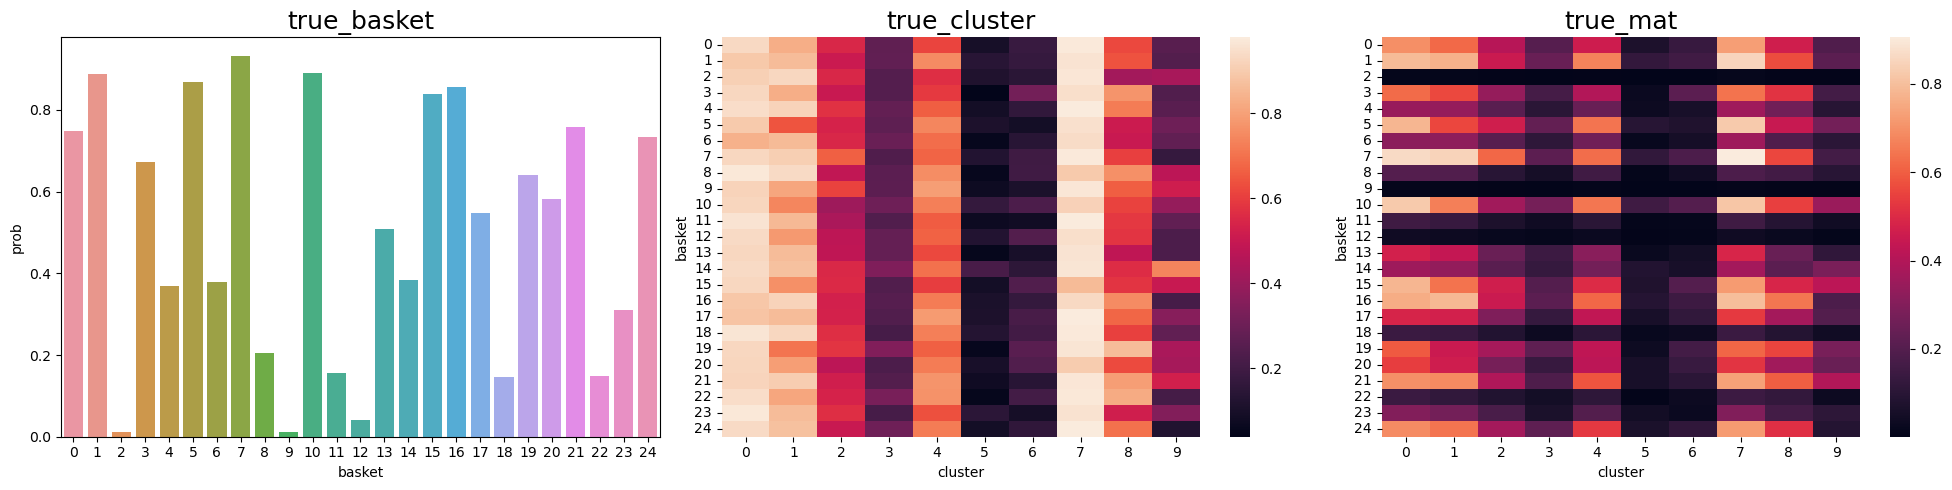

In [8]:
plot_basket_and_cluster(true_basket_p, true_cluster_p, true_mat, out_file='synthetic_1.png')

Using OOP

In [9]:
# Set the seed value
seed_value = 42

# Set `random` seed
random.seed(seed_value)

# Set `numpy` seed
np.random.seed(seed_value)

In [10]:
n_patients = 500
n_tissues = 25
n_clusters = 10
enrollments = [[n_patients] for _ in range(n_tissues)]
enrollments = [[n_patients] for _ in range(n_tissues)]
site = TrueResponseWithClusteringSite(enrollments, n_tissues, n_clusters)

In [11]:
enrollments

[[500],
 [500],
 [500],
 [500],
 [500],
 [500],
 [500],
 [500],
 [500],
 [500],
 [500],
 [500],
 [500],
 [500],
 [500],
 [500],
 [500],
 [500],
 [500],
 [500],
 [500],
 [500],
 [500],
 [500],
 [500]]

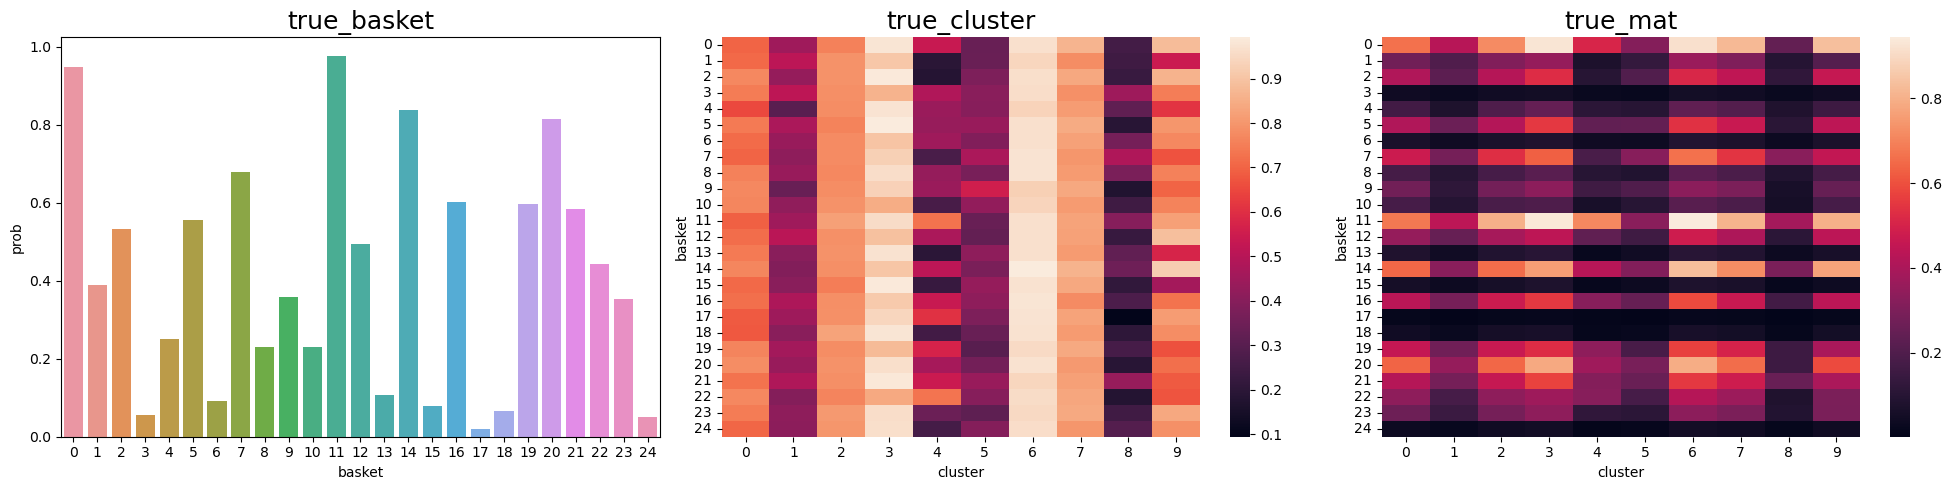

In [12]:
plot_basket_and_cluster(site.true_basket_p, site.true_cluster_p, site.true_mat, out_file='synthetic_2.png')

In [13]:
site.enroll(0)

PatientData:
responses [1 1 0 0 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 0 1 1 1 0 1 0 0 0 1 0 1 1 1 1 0 0 1
 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 0 0
 0 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 1 1 0 1 0
 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0
 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0
 1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 1 1 1 0 1 0 1 0 1
 1 0 0 0 1 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0
 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1 0 1 0 0 0 1 0 1
 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0
 1 1 1 0 1 1 0 1 1 1 0 0 1 0 1 0 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1
 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0
 0 1 0 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 1 1 0 0 1 1 1 0 0 0 0 1 0 1
 0 0 1 1 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0 1 1 1
 1

In [14]:
site.enroll(0)

2023-06-19 14:41:31.749 | WARNING  | pyBasket.env:enroll:127 - Enrollment has been closed for group 0


In [15]:
site.enroll(1)

PatientData:
responses [0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0
 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1
 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1
 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 0

In [16]:
site.enroll(1)

2023-06-19 14:41:31.826 | WARNING  | pyBasket.env:enroll:127 - Enrollment has been closed for group 1


Now try with known true response rates

In [17]:
K = 6    # the number of groups
p0 = 0.2 # null response rate
p1 = 0.4 # target response rate
n_clusters = 10

true_response_rates = [p0, p0, p0, p1, p1, p1]
enrollments = [14, 10] * K

site = TrueResponseWithClusteringSite(enrollments, K, n_clusters, true_response_rates=true_response_rates)

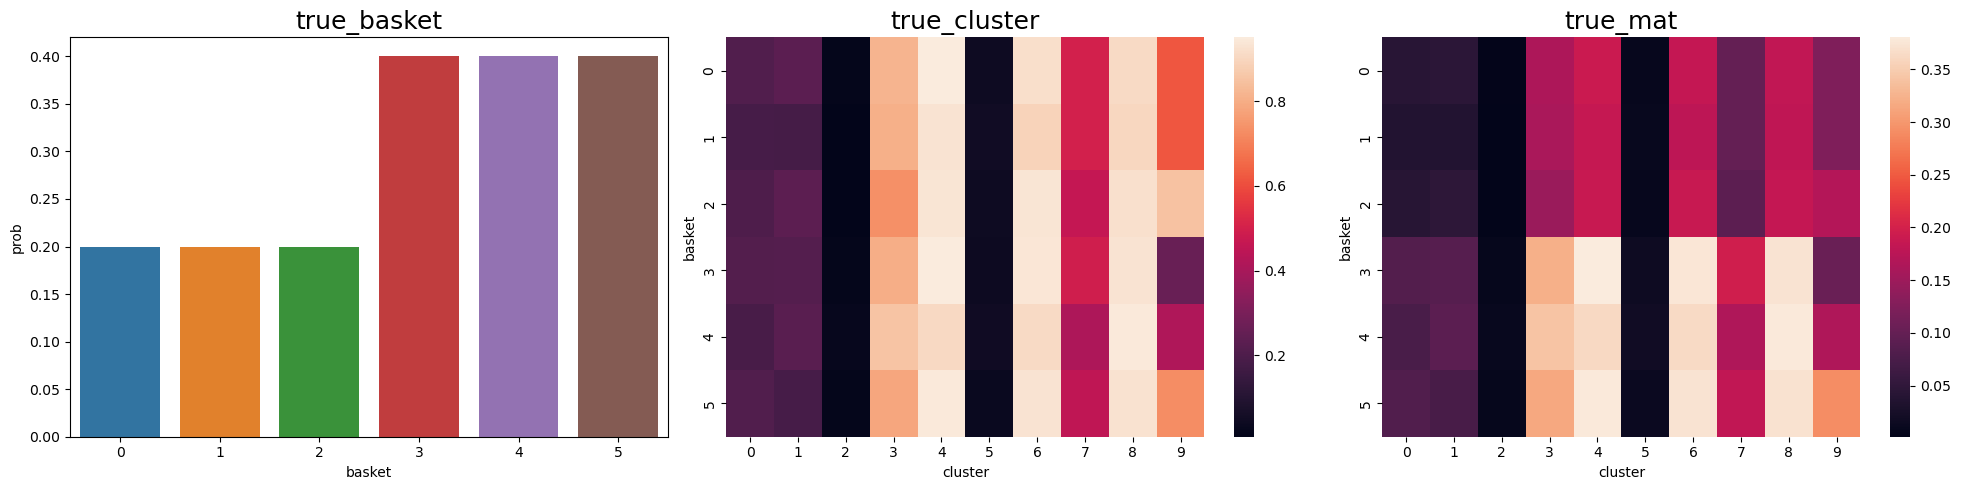

In [18]:
plot_basket_and_cluster(site.true_basket_p, site.true_cluster_p, site.true_mat)